# Homework 7: Jena Climate Dataset
- 2009년부터 2016년까지의 날씨 데이터를 바탕으로 기상예측을 해보자
- 시계열 데이터로 예측을 하기 위해 LSTM 을 사용한다.

### 1. Load the Dataset

In [1]:
import pandas as pd
import numpy as np
import datetime
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns


climate = pd.read_csv("./jena_climate_2009_2016.csv")
print(climate.shape)
climate.head()

(420551, 15)


,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


### 2. Data Visualization

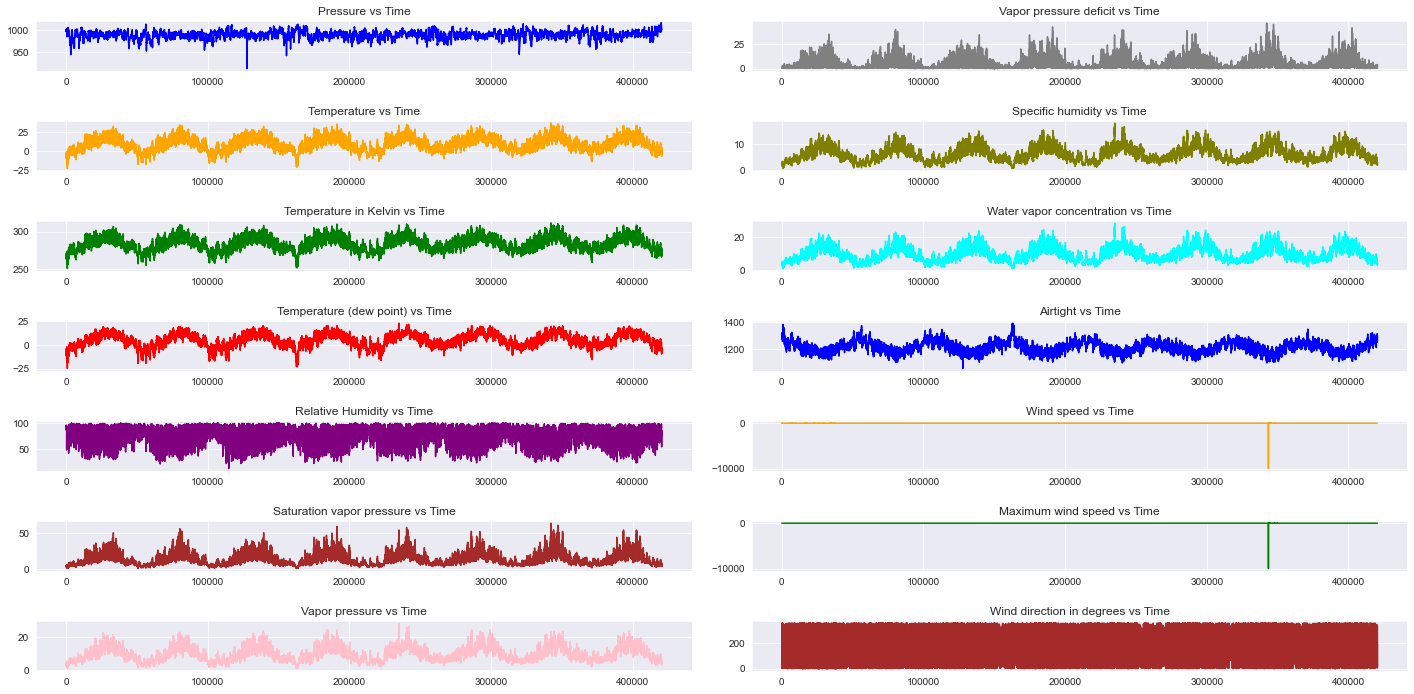

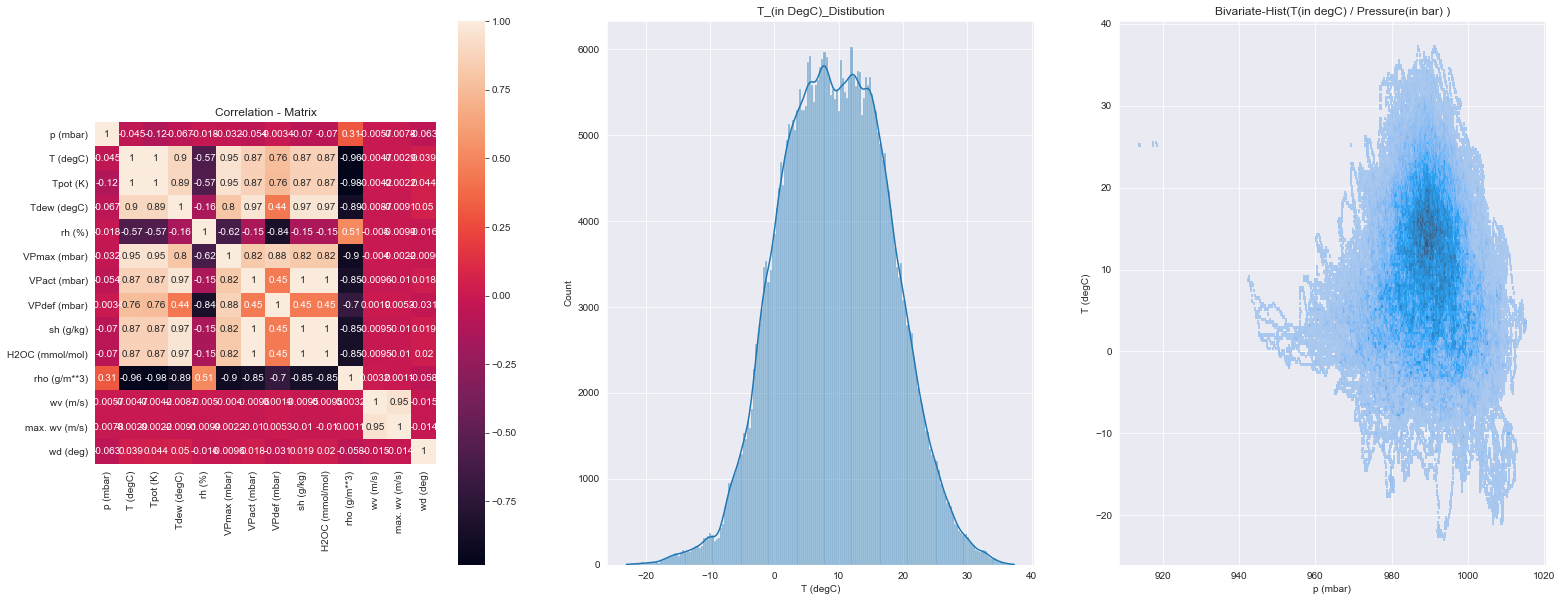

In [2]:
all_cols = climate.columns
sns.set_style('darkgrid')
fig, axs = plt.subplots(7,2 , figsize=(20,10))

# 데이터프레임에 약자로 표현된 날씨 feature 들을 정의해줌
titles = [
    "Pressure",
    "Temperature",
    "Temperature in Kelvin",
    "Temperature (dew point)",
    "Relative Humidity",
    "Saturation vapor pressure",
    "Vapor pressure",
    "Vapor pressure deficit",
    "Specific humidity",
    "Water vapor concentration",
    "Airtight",
    "Wind speed",
    "Maximum wind speed",
    "Wind direction in degrees",
]

colors = [
    "blue",
    "orange",
    "green",
    "red",
    "purple",
    "brown",
    "pink",
    "gray",
    "olive",
    "cyan",
    "blue",
    "orange",
    "green",
    "brown",
]

# 시간에 따른 X의 변화 시각화
for i in range(len(titles)):
    
    if i<= 6:
        axs[i,0].set_title(f'{titles[i]} vs Time');
        axs[i,0].plot(range(len(climate[all_cols[0]])), climate[all_cols[i+1]],c = colors[i]);
    if i > 6:
        axs[i-7,1].set_title(f'{titles[i]} vs Time');
        axs[i-7,1].plot(range(len(climate[all_cols[0]])), climate[all_cols[i+1]],c = colors[i]);
        

plt.tight_layout(pad=2)
plt.show()

# 날씨 요소간 상관관계 파악을 위해 히트맵 출력
fig, ax = plt.subplots(1,3, figsize = (26,10))
climate_corr = climate.corr()
ax[0].set_title('Correlation - Matrix')
sns.heatmap(climate_corr, square=True, annot=True, ax=ax[0]);

ax[1].set_title('T_(in DegC)_Distibution')
sns.histplot(climate[all_cols[2]], ax = ax[1], kde =True);
 
ax[2].set_title('Bivariate-Hist(T(in degC) / Pressure(in bar) )')
sns.histplot(
    climate, x=all_cols[1], y=all_cols[2],
    discrete=(False, False), log_scale=(False, False), ax= ax[2]
);

plt.show()

### 3. Data Pre-processing

학습에 필요한 feature 만 빼고 나머지 feature 는 삭제한다. 시각화 결과를 바탕으로 시간의 흐름에 따른 날씨 예측에 중요하다고 판단되는 feature 는 다음과 같다.

- "Temperature",
- "Temperature in Kelvin",
- "Temperature (dew point)",
- "Relative Humidity",
- "Saturation vapor pressure",
- "Vapor pressure",
- "Vapor pressure deficit",
- "Specific humidity",
- "Water vapor concentration",
- "Airtight"

In [3]:
new_climate = climate.loc[:, ['Date Time', 'T (degC)', 'Tpot (K)', 'Tdew (degC)', 'rh (%)', 'VPmax (mbar)', 'VPact (mbar)',
                             'VPdef (mbar)', 'sh (g/kg)', 'H2OC (mmol/mol)', 'rho (g/m**3)']]
new_climate

,Date Time,T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3)
0,01.01.2009 00:10:00,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75
1,01.01.2009 00:20:00,-8.41,265.01,-9.28,93.40,3.23,3.02,0.21,1.89,3.03,1309.80
2,01.01.2009 00:30:00,-8.51,264.91,-9.31,93.90,3.21,3.01,0.20,1.88,3.02,1310.24
3,01.01.2009 00:40:00,-8.31,265.12,-9.07,94.20,3.26,3.07,0.19,1.92,3.08,1309.19
4,01.01.2009 00:50:00,-8.27,265.15,-9.04,94.10,3.27,3.08,0.19,1.92,3.09,1309.00
...,...,...,...,...,...,...,...,...,...,...,...
420546,31.12.2016 23:20:00,-4.05,269.10,-8.13,73.10,4.52,3.30,1.22,2.06,3.30,1292.98
420547,31.12.2016 23:30:00,-3.35,269.81,-8.06,69.71,4.77,3.32,1.44,2.07,3.32,1289.44
420548,31.12.2016 23:40:00,-3.16,270.01,-8.21,67.91,4.84,3.28,1.55,2.05,3.28,1288.39
420549,31.12.2016 23:50:00,-4.23,268.94,-8.53,71.80,4.46,3.20,1.26,1.99,3.20,1293.56


그리고, Date Time 에 담긴 날짜 정보만 따로 뽑아서 넘파이 배열로 만들어준다.

In [4]:
date_time = pd.to_datetime(new_climate.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')
new_climate

,T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3)
0,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75
1,-8.41,265.01,-9.28,93.40,3.23,3.02,0.21,1.89,3.03,1309.80
2,-8.51,264.91,-9.31,93.90,3.21,3.01,0.20,1.88,3.02,1310.24
3,-8.31,265.12,-9.07,94.20,3.26,3.07,0.19,1.92,3.08,1309.19
4,-8.27,265.15,-9.04,94.10,3.27,3.08,0.19,1.92,3.09,1309.00
...,...,...,...,...,...,...,...,...,...,...
420546,-4.05,269.10,-8.13,73.10,4.52,3.30,1.22,2.06,3.30,1292.98
420547,-3.35,269.81,-8.06,69.71,4.77,3.32,1.44,2.07,3.32,1289.44
420548,-3.16,270.01,-8.21,67.91,4.84,3.28,1.55,2.05,3.28,1288.39
420549,-4.23,268.94,-8.53,71.80,4.46,3.20,1.26,1.99,3.20,1293.56


In [5]:
timestamp_s = date_time.map(datetime.datetime.timestamp)
day = 24*60*60
year = (365.2425)*day


new_climate['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
new_climate['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
new_climate['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
new_climate['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

시계열 데이터는 시간에 변화에 따른 요소의 변화가 중요하기 때문에 Year, Day 의 넘파이 sin 값, cos 값을 데이터프레임에 저장해준다.

sin 함수, cos 함수를 사용해 주기적인 패턴을 만들어준다.

In [6]:
new_climate.head()

,T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),Day sin,Day cos,Year sin,Year cos
0,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,-0.737277,-0.675590,0.003001,0.999995
1,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,-0.766044,-0.642788,0.003120,0.999995
2,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,-0.793353,-0.608761,0.003240,0.999995
3,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,-0.819152,-0.573576,0.003359,0.999994
4,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,-0.843391,-0.537300,0.003479,0.999994


In [7]:
new_climate.tail()

,T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),Day sin,Day cos,Year sin,Year cos
420546,-4.05,269.10,-8.13,73.10,4.52,3.30,1.22,2.06,3.30,1292.98,-0.573576,-0.819152,0.003436,0.999994
420547,-3.35,269.81,-8.06,69.71,4.77,3.32,1.44,2.07,3.32,1289.44,-0.608761,-0.793353,0.003555,0.999994
420548,-3.16,270.01,-8.21,67.91,4.84,3.28,1.55,2.05,3.28,1288.39,-0.642788,-0.766044,0.003675,0.999993
420549,-4.23,268.94,-8.53,71.80,4.46,3.20,1.26,1.99,3.20,1293.56,-0.675590,-0.737277,0.003794,0.999993
420550,-4.82,268.36,-8.42,75.70,4.27,3.23,1.04,2.01,3.23,1296.38,-0.707107,-0.707107,0.003914,0.999992


데이터를 train 과 validation 데이터로 나누고, 데이터의 단위가 모두 다르므로, Normalising 을 진행한다.

In [27]:
split_fraction = 0.75075
train_split = int(split_fraction * int(new_climate.shape[0]))

step = 6
past = 720
future = 72
batch_size = 32

data_mean = new_climate[:train_split].mean(axis=0)
data_std = new_climate[:train_split].std(axis=0)

new_climate=(new_climate-data_mean)/data_std

In [9]:
new_climate=new_climate.values
new_climate = pd.DataFrame(new_climate)
new_climate.head()

train_data = new_climate.loc[0 : train_split - 1]
val_data = new_climate.loc[train_split:]

In [10]:
train_data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,-2.015259,-2.075258,-1.976874,1.026199,-1.324583,-1.511443,-0.779410,-1.514426,-1.516700,2.251541,-1.042926,-0.955599,0.002999,1.414931
1,-2.060942,-2.120559,-2.031777,1.032276,-1.337777,-1.532865,-0.781523,-1.533176,-1.537863,2.302216,-1.083607,-0.909206,0.003168,1.414930
2,-2.072655,-2.132175,-2.036112,1.062661,-1.340416,-1.535245,-0.783635,-1.536926,-1.540214,2.313093,-1.122225,-0.861084,0.003337,1.414930
3,-2.049228,-2.107782,-2.001436,1.080892,-1.333819,-1.520964,-0.785748,-1.521926,-1.526106,2.287137,-1.158708,-0.811322,0.003505,1.414929
4,-2.044543,-2.104297,-1.997102,1.074815,-1.332499,-1.518584,-0.785748,-1.521926,-1.523754,2.282441,-1.192986,-0.760016,0.003674,1.414928


In [11]:
val_data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
315728,-0.821647,-0.986876,-0.400580,1.366514,-0.821883,-0.568883,-0.808989,-0.603168,-0.601974,1.342107,-0.861188,-1.122150,-0.008747,1.414917
315729,-0.820475,-0.985714,-0.400580,1.360437,-0.820564,-0.568883,-0.806876,-0.603168,-0.601974,1.340871,-0.909305,-1.083527,-0.008578,1.414918
315730,-0.822818,-0.989199,-0.403470,1.360437,-0.821883,-0.571263,-0.806876,-0.603168,-0.604325,1.344826,-0.955692,-1.042842,-0.008409,1.414919
315731,-0.834532,-1.000815,-0.417918,1.360437,-0.828480,-0.585544,-0.806876,-0.614418,-0.616083,1.355702,-1.000261,-1.000172,-0.008240,1.414920
315732,-0.823989,-0.989199,-0.403470,1.366514,-0.823202,-0.571263,-0.808989,-0.603168,-0.601974,1.344826,-1.042926,-0.955599,-0.008071,1.414921


## Experiment using 'LSTM'
LSTM 은 시계열 데이터처럼 아주 긴 시퀸스 데이터를 대상으로 모델링을 할 때 많이 쓰인다. 따라서 다년간의 날씨 예측을 하기 위해 LSTM 을 사용한다.
- activation function: sigmoid
- optimizer: Adam
- loss function: mse
- batch size: 32
- epoch: 10

In [12]:
start = past + future
end = start + train_split

x_train = train_data[[i for i in range(10)]].values
y_train = new_climate.iloc[start:end][[1]]

sequence_length = int(past / step) # 120

In [13]:
print('X_train shape == {}.'.format(x_train.shape)) # feature 10가지
print('y_train shape == {}.'.format(y_train.shape)) # 예측값 1

X_train shape == (315728, 10).
y_train shape == (315728, 1).


In [14]:
from __future__ import print_function

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras import models
from keras import layers
import tensorflow as tf
from tensorflow import keras

#### 데이터 불러오기

In [30]:
dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    x_train,
    y_train,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)

In [31]:
x_end = len(val_data) - past - future

label_start = train_split + past + future

x_val = val_data.iloc[:x_end][[i for i in range(10)]].values
y_val = new_climate.iloc[label_start:][[1]]

dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    x_val,
    y_val,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)


for batch in dataset_train.take(1):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (32, 120, 10)
Target shape: (32, 1)


#### 모델 생성하고 컴파일하기

In [32]:
inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
lstm_out = keras.layers.LSTM(24)(inputs)
outputs = keras.layers.Dense(1)(lstm_out)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='mse')
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 120, 10)]         0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 24)                3360      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 25        
Total params: 3,385
Trainable params: 3,385
Non-trainable params: 0
_________________________________________________________________


#### 학습 시작하기

In [33]:
history = model.fit(
          dataset_train,
          epochs=5,
          validation_data=dataset_val)

Epoch 1/5
9845/9845 [==============================] - 247s 25ms/step - loss: 0.2545 - val_loss: 0.2611
Epoch 2/5
9845/9845 [==============================] - 245s 25ms/step - loss: 0.1554 - val_loss: 0.2188
Epoch 3/5
9845/9845 [==============================] - 242s 25ms/step - loss: 0.1470 - val_loss: 0.2039
Epoch 4/5
9845/9845 [==============================] - 242s 25ms/step - loss: 0.1455 - val_loss: 0.1922
Epoch 5/5
9845/9845 [==============================] - 22954s 2s/step - loss: 0.1401 - val_loss: 0.1888


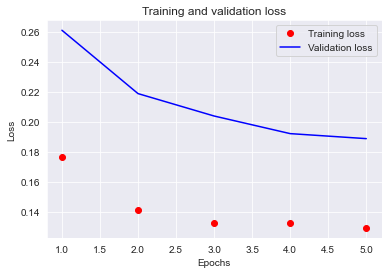

In [34]:
# loss 의 변화 시각화

history_dict = history.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1,len(loss)+1)

plt.plot(epochs, loss, 'bo', label='Training loss', color='red')
plt.plot(epochs, val_loss, 'b', label='Validation loss', color = 'blue')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Results
